In [1]:
import numpy as np
import datetime

from btgym import BTgymEnv, BTgymDataset
from btgym import BTgymRandomDataDomain, BTgymSequentialDataDomain
from btgym import DataSampleConfig, EnvResetConfig

from logbook import WARNING, INFO, DEBUG

### Motivation

- BTGym data is basically discrete timeflow of equitype records. For the sake of
defining episodic MDP over such data and setting formal problem objective it should
be somehow structured. 

- From the other hand, all train data can laso be seen as big external replay memory. Giving algorithms some degree of control over data sampling parameters can be beneficial for overal performance.

- The idea is to pass all desirable sample properties as kwargs to env.rest() method.

- This notebook is brief introduction to API realisation of formal definitions introduced in Section 1 (Data) in     this draft: https://github.com/Kismuz/btgym/blob/master/docs/papers/btgym_formalism_draft.pdf

- objects described here can be thought as nested data containers with bult-in properties like sampling and         splitting data to train and test subsets.

In [2]:
# Make data domain - top-level data structure:
domain = BTgymRandomDataDomain(
    filename='../examples/data/DAT_ASCII_EURUSD_M1_2016.csv',
    target_period={'days': 50, 'hours': 0, 'minutes': 0},  # use last 50 days of one year data as 'target domain'
                                                           # so we get [360 - holidays gaps - 50] 
                                                           # days of train data (exclude holidays)
    trial_params=dict(
        start_weekdays={0, 1, 2, 3, 4, 5, 6}, 
        sample_duration={'days': 30, 'hours': 0, 'minutes': 0}, # let each trial be 10 days long
        start_00=True,  # ajust trial beginning to the beginning of the day
        time_gap={'days': 15, 'hours': 0},  # tolerance param 
        test_period={'days': 6, 'hours': 0, 'minutes': 0},  # from those 10 reserve last 2 days for trial test data
    ),
    episode_params=dict(
        start_weekdays={0, 1, 2, 3, 4, 5, 6},
        sample_duration={'days': 0, 'hours': 23, 'minutes': 55},  # make every episode duration be 23:55 
        start_00=False, # do not ajust beginning time
        time_gap={'days': 0, 'hours': 10},
    ),
    log_level=INFO, # Set to DEBUG to see more output
)

Here Domain instanse is defined such as:
- Holds one yera of 1min bars data;
- Splits data to source and target domains, target domain data gets last 29 days of year period;
- Defines each Trial to consist of 8 days of train and following 2 days of test data;
- Each Episode lasts maximum 23:55.

### Sampling parameters

- For convinience currently implemented control options are referenced in `btgym.datafeed.base.DataSampleConfig`:
```
DataSampleConfig = dict(
    get_new=True,
    sample_type=0,
    b_alpha=1,
    b_beta=1
)
```
...which simply mirrors base data sample() kwargs:

        Args:
            get_new (bool):                 sample new (True) or reuse (False) last made sample;
            sample_type (int or bool):      0 (train) or 1 (test) - get sample from train or test data subsets
                                            respectively.
            b_alpha (float):                beta-distribution sampling alpha > 0, valid for train episodes.
            b_beta (float):                 beta-distribution sampling beta > 0, valid for train episodes.



- environment reset kwargs are referenced in `btgym.datafeed.base.EnvResetConfig`:
```
EnvResetConfig = dict(
    episode_config=DataSampleConfig,
    trial_config=DataSampleConfig,
)
```


### Sampling cycle

- Reset domain which mean load and describe data and reset counters in case of stateful classes such as BTgymSequentialDataDomain:

In [3]:
domain.reset()

[2018-07-07 06:09:14.150795] INFO: RndDataDomain_0: Loaded 372678 records from <../examples/data/DAT_ASCII_EURUSD_M1_2016.csv>.


##### Sample trial from source domain:

In [5]:
trial= domain.sample(
    get_new=True,
    sample_type=0,
    b_alpha=1,
    b_beta=1
)

trial.reset()

[2018-07-07 06:09:25.068405] INFO: RndDataDomain_0: New sample id: <train_trial_w_0_num_1_at_2016-09-07>.


- Here new Trial object from `Source`(or train) domaini have been requested as uniform sample from entire source data interval

- If target period duration is set to 0:0:0, trying to get target sample will rise an exeption.

- Need to reset before sampling as well:

- Implementatdion detail: 
    - during real BTgym operation domain instance is held by `btgym_data_server`;

    - Different Trial samples are sent to every environment instance, so corresponding `btgym_server` can sample           multiple episodes 'in place'.


##### Sample episode from trial test interval:

In [6]:
episode = trial.sample(
    get_new=True,
    sample_type=1,
    b_alpha=1,
    b_beta=1
)


[2018-07-07 06:09:28.047474] INFO: Trial_0: New sample id: <test_episode_w_0_num_0_at_2016-10-17 13:18:00>.


- Episodes can be sampled from Trial `train` or `test` subsets, just like Trials from Source/Target domains. Here new Episode from test subset of the Trial is requested. Since it is test subset, alpha and beta params doesnt count - it is always uniform (just a common sense heuristic, one can always change it)     



#### Convert to bt.feed object:

In [7]:
data_feed = episode.to_btfeed()

##### Now print whole path:

In [14]:
print('Got instance of: {}\nholding data: {}\nmetadata: {}'.
      format(type(domain), domain.filename, domain.metadata))

print('  |\nsample()\n  |')

print('got instance of: {}\nholding data: {}\nmetadata: {}'.
      format(type(trial), trial.filename, trial.metadata))

print('  |\nsample()\n  |')

print('got instance of: {}\nholding data: {}\nmetadata: {}'.
      format(type(episode), episode.filename, episode.metadata))

print('  |\nto_btfeed()\n  |')

print('got instance of: {}\n...holding default data line: {}, wi ready to be fed to bt.Cerebro.'.format(type(data_feed), data_feed))

Got instance of: <class 'btgym.datafeed.derivative.BTgymRandomDataDomain'>
holding data: ['../examples/data/DAT_ASCII_EURUSD_M1_2016.csv']
metadata: {'sample_num': 0, 'type': None}
  |
sample()
  |
got instance of: <class 'btgym.datafeed.derivative.BTgymDataTrial'>
holding data: train_trial_w_0_num_1_at_2016-09-07
metadata: {'sample_num': 1, 'type': 0, 'first_row': 254819, 'last_row': 298019, 'parent_sample_num': 0, 'parent_sample_type': None}
  |
sample()
  |
got instance of: <class 'btgym.datafeed.derivative.BTgymEpisode'>
holding data: test_episode_w_0_num_0_at_2016-10-17 13:18:00
metadata: {'sample_num': 0, 'type': 1, 'first_row': 41030, 'last_row': 42465, 'parent_sample_num': 1, 'parent_sample_type': 0}
  |
to_btfeed()
  |
got instance of: <class 'dict'>
...holding default data line: {'base_data_line': <backtrader.feeds.pandafeed.PandasDirectData object at 0x10f5a4a58>}, wich value is ready to be fed to bt.Cerebro.


##### Note:
- BTgymDataSet class used in most examples is simply special case where we set Trial=Episode by definition.
- This nested data structure is intended mostly for upcoming implementation of meta-learning and guided-policy-search algorithms.

### Skewed sampling

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Beta-distribution quick recap:

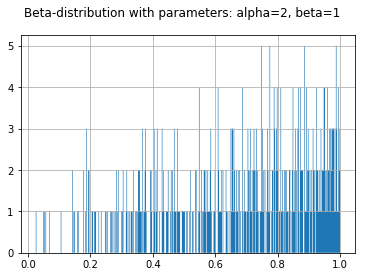

In [100]:
alpha, beta, size = 2, 1, 500

y = np.random.beta(alpha, beta, size)

plt.figure(0)
plt.suptitle(
    'Beta-distribution with parameters: alpha={}, beta={}'.format(alpha, beta), fontsize=12
)
plt.grid(True)
fig = plt.hist(y, histtype='stepfilled', bins=500)

#### What it looks like for an episode: 
- here we plot a histogram of first record time-dates for set of sampled test and train episodes

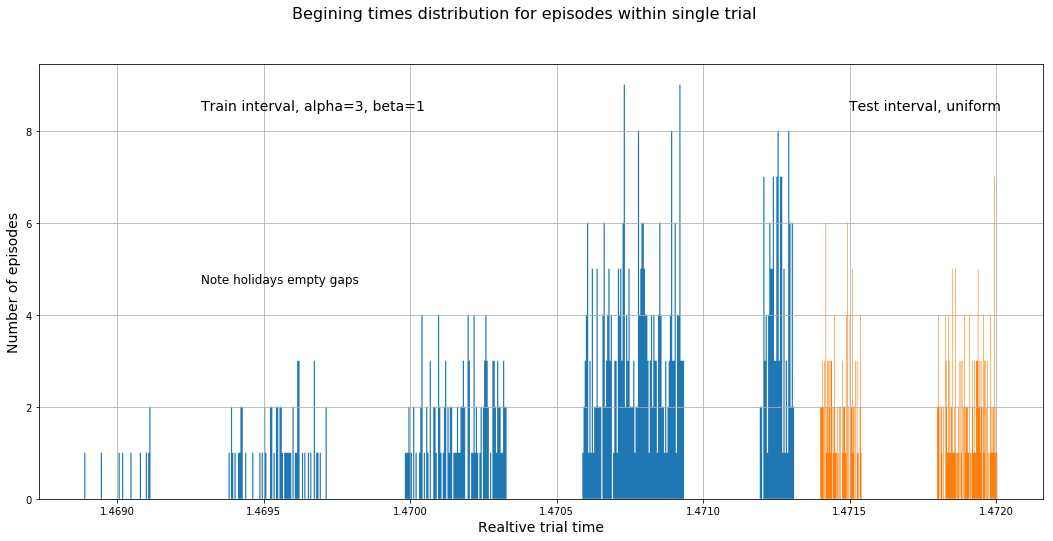

In [107]:
# Suppose Trial is ready, if no - use cells above to get one

trial.set_logger(level=13) # make it qiuet

train_num_samples = 600
test_num_samples = 300

# Beta distribution paramters:
alpha = 3 # give priority to recent samples 
beta = 1

train_start = np.zeros(train_num_samples)
test_start = np.zeros(test_num_samples)

# Sample train episode and get time of first record as some realtive number:
for i in range(train_num_samples):
    train_start[i] = trial.sample(True, 0, alpha, beta).data[0:1].index[0].value / 1e18
    
# Sample test episode and get time of first record as number:
for i in range(test_num_samples):
    test_start[i] = trial.sample(True, 1, alpha, beta).data[0:1].index[0].value / 1e18
    

fig = plt.figure(1, figsize=(18,8))
plt.suptitle('Begining times distribution for episodes within single trial', fontsize=16)
plt.xlabel('Realtive trial time', fontsize=14)
plt.ylabel('Number of episodes', fontsize=14)
fig.text(0.25, 0.8, 'Train interval, alpha={}, beta={}'.format(alpha, beta), fontsize=14)
fig.text(0.75, 0.8, 'Test interval, uniform', fontsize=14)
fig.text(0.25, 0.5, 'Note holidays empty gaps', fontsize=12)

plt.grid(True)
fig = plt.hist(train_start, histtype='stepfilled', bins=train_num_samples)
fig = plt.hist(test_start, histtype='stepfilled', bins=test_num_samples)


### Running environment

TODO